In [16]:
%pip install pm4py
%pip install seaborn
%pip install numpy
%pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [17]:
import pandas as pd
import pm4py
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [18]:
log_csv = pd.read_csv('https://raw.githubusercontent.com/paoloceravolo/PM-Regensburg/main/ArtificialPatientTreatment.csv', sep=',')
log_csv = dataframe_utils.convert_timestamp_columns_in_df(log_csv)

# Using alpha miner to find a Petri Net

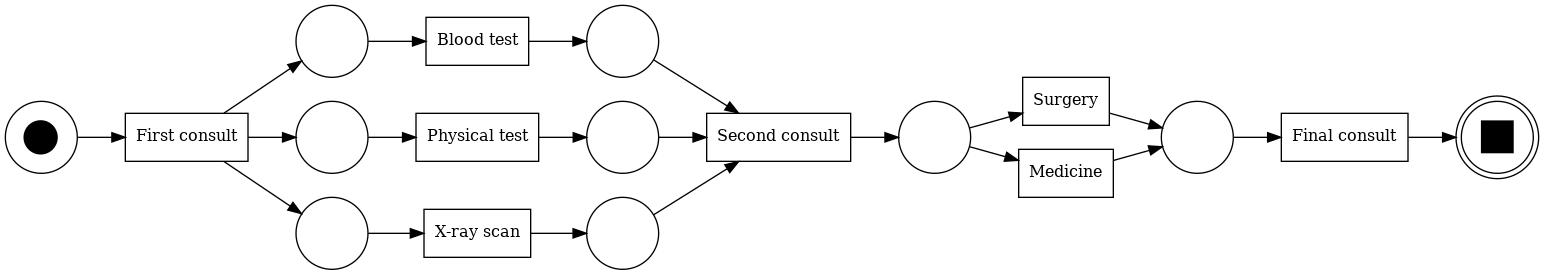

In [42]:
net, initial_marking, final_marking = pm4py.discover_petri_net_alpha(log_csv)
pm4py.view_petri_net(net, initial_marking, final_marking)

With this discovery methods we get to know that all the activities start with a **First consult** and end with a **Final Consult**. Passing from some alternative paths in the middle, usually leading in a second consult.

# Using an Inductive miner to derive a Petri Net and a Process tree

## Also using a DFG avoiding recursion on the sublogs

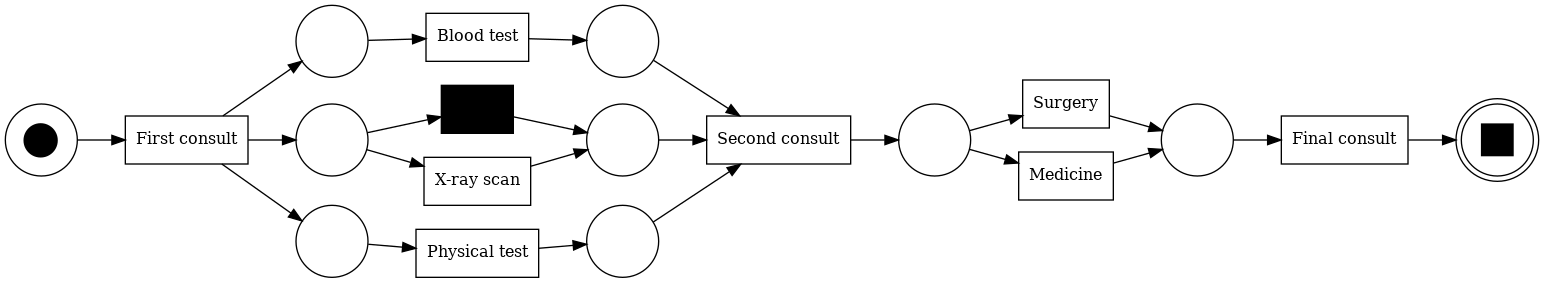

In [43]:
net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(log_csv)
pm4py.view_petri_net(net, initial_marking, final_marking)

With the Inductive miner we get to know that there is a hidden activity, opposed to **X-ray scan**.

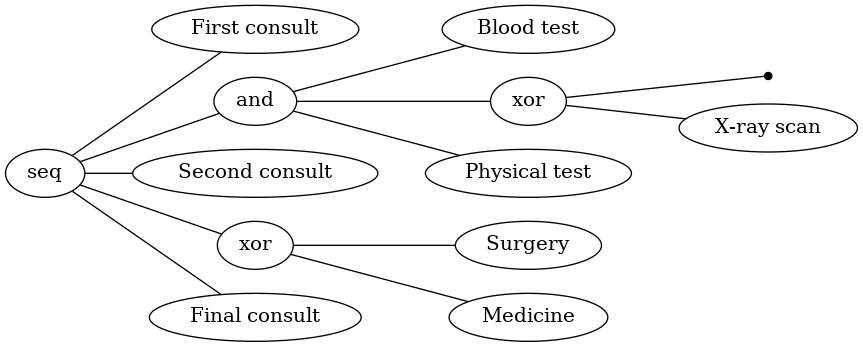

In [44]:
tree = pm4py.discover_process_tree_inductive(log_csv)
pm4py.view_process_tree(tree)

We can also see a process tree, that inform us with the sequence of activities that can be taken or have to be taken (*and* and *xor*)

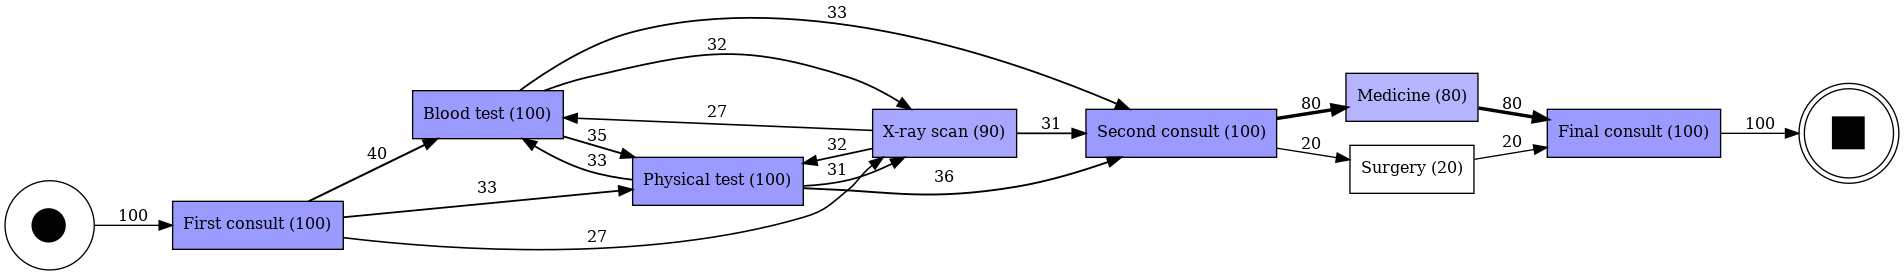

In [46]:
dfg, start_activities, end_activities = pm4py.discover_dfg(log)
pm4py.view_dfg(dfg, start_activities, end_activities)

With this kind of graph we can see the percentage of transitions that go into the  different activities, including the different paths that they can follow.

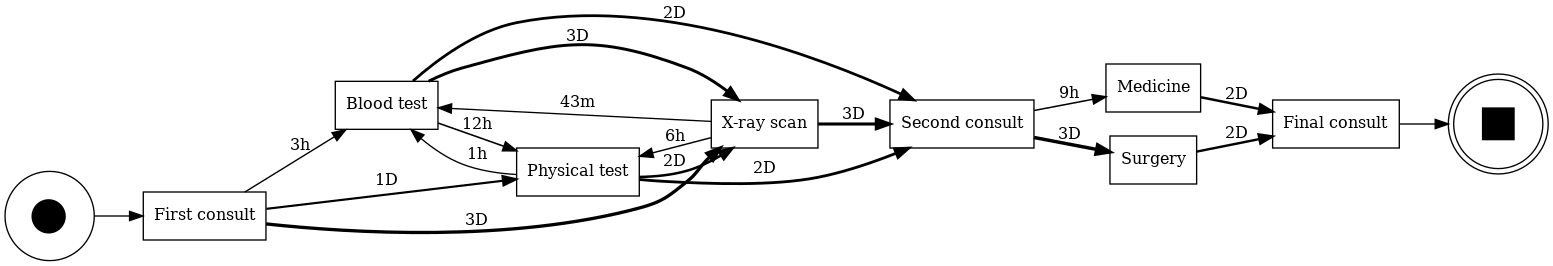

In [47]:
performance_dfg, start_activities, end_activities = pm4py.discover_performance_dfg(log)
pm4py.view_performance_dfg(performance_dfg, start_activities, end_activities)

There is also a way to see the DFG without the percentage, but with the performance, in this case the time that occur between activities. We are now ready to sum up the performance to know the mean time of a path.

# Using an Heuristic Miner to handle noise and find common constructs (EG: dependencies bewteen 2 activities)

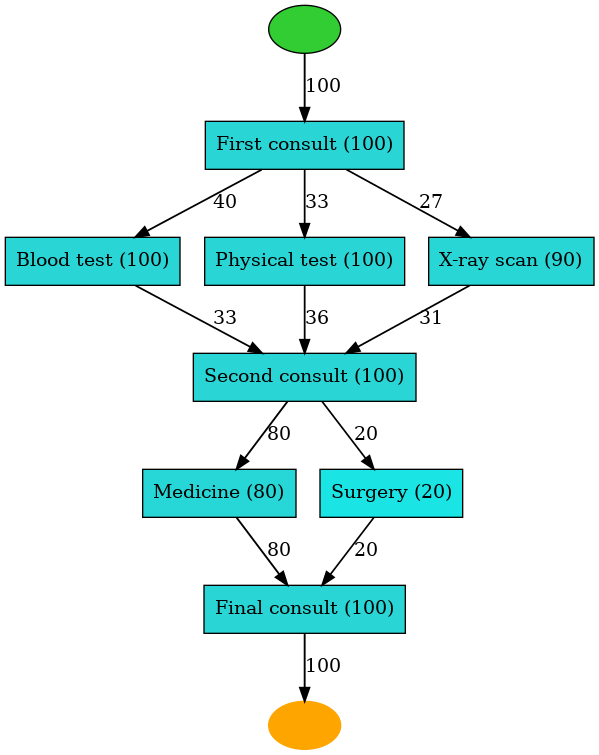

In [56]:
heu_net = pm4py.discover_heuristics_net(log_csv, dependency_threshold=0.95)
pm4py.view_heuristics_net(heu_net)

Using a threesold like 0.95, in this case, I am able to include all the path that compose our dataset. Adding only a 0.01 something will be excluded from the net. However a threesold like 0.95 seems to be accurate in my point of view.

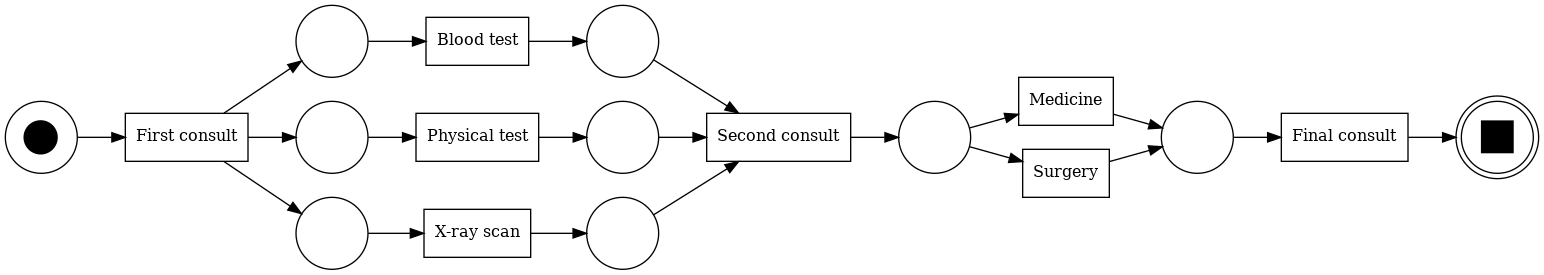

In [61]:
net, im, fm = pm4py.discover_petri_net_heuristics(log_csv, dependency_threshold=0.95)
pm4py.view_petri_net(net, im, fm)

Trying different threesold i have discovered some hidden transition, but they are not relevant in my point of view. However by taking the same threesold of the heuritic net we obtain the same result.

In [19]:
# Create a pivot table of the start (minimum) and end (maximum) timestamps associated with each case:
case_starts_ends = log_csv.pivot_table(index='patient', aggfunc={'datetime': ['min', 'max']})
case_starts_ends = case_starts_ends.reset_index()
case_starts_ends.columns = ['patient', 'caseend', 'casestart']
# Merge with the main event log data so that for each row we have the start and end times.
log_csv = log_csv.merge(case_starts_ends, on='patient')
# Calculate the relative time by subtracting the process start time from the event timestamp
log_csv['cumulativetime'] = log_csv['datetime'] - log_csv['casestart']
# Convert relative times to more friendly measures
## seconds
log_csv['cumulativetime_s'] = log_csv['cumulativetime'].dt.seconds + 86400*log_csv['cumulativetime'].dt.days
## days
log_csv['cumulativedays'] = log_csv['cumulativetime'].dt.days

#print(log_csv)

([<matplotlib.axis.YTick at 0x74942b509420>,
 [Text(0, 0, 'patient0'),
  Text(0, 5, 'patient5'),
  Text(0, 10, 'patient10'),
  Text(0, 15, 'patient15'),
  Text(0, 20, 'patient20'),
  Text(0, 25, 'patient25'),
  Text(0, 30, 'patient30'),
  Text(0, 35, 'patient35'),
  Text(0, 40, 'patient40'),
  Text(0, 45, 'patient45'),
  Text(0, 50, 'patient50'),
  Text(0, 55, 'patient55'),
  Text(0, 60, 'patient60'),
  Text(0, 65, 'patient65'),
  Text(0, 70, 'patient70'),
  Text(0, 75, 'patient75'),
  Text(0, 80, 'patient80'),
  Text(0, 85, 'patient85'),
  Text(0, 90, 'patient90'),
  Text(0, 95, 'patient95')])

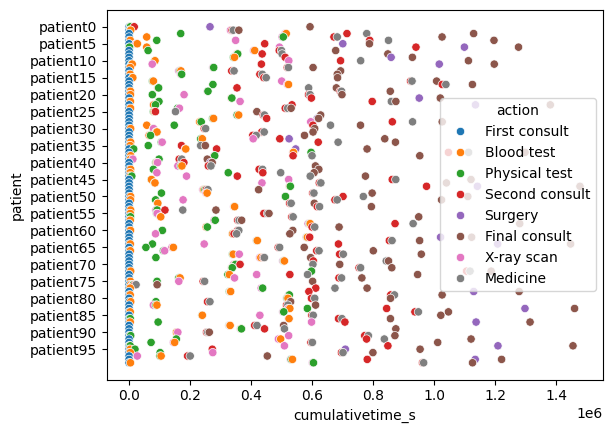

In [20]:
## Get an array of patient labels for the y axis - for graph labelling purposes
patientnums = [int(e) for e in log_csv['patient'].apply(lambda x: x.strip('patient'))]
## Plot a scatter plot of patient events over relative time
ax = sns.scatterplot(x=log_csv['cumulativetime_s'],
y=log_csv['patient'], hue=log_csv['action'])
## Set y axis ticks so that you only show every 5th patient - for readability
plt.yticks(np.arange(min(patientnums), max(patientnums)+1, 5))

<Axes: xlabel='action', ylabel='patient'>

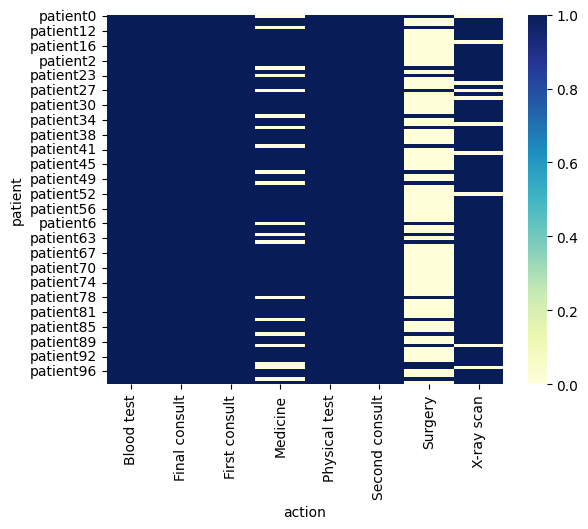

In [21]:
## Create a table giving the number of cases in which each event is present.
patient_events = pd.crosstab(log_csv['patient'], log_csv['action'])
## Visualise in a heatmap
sns.heatmap(patient_events, cmap="YlGnBu")

In [22]:
# Comply to the naming standard of PM4PY

log_csv.rename(columns={'datetime': 'time:timestamp',
'patient': 'case:concept:name', 'action': 'concept:name', 'resource': 'org:resource'}, inplace=True)

## Convert to log format
log = log_converter.apply(log_csv)

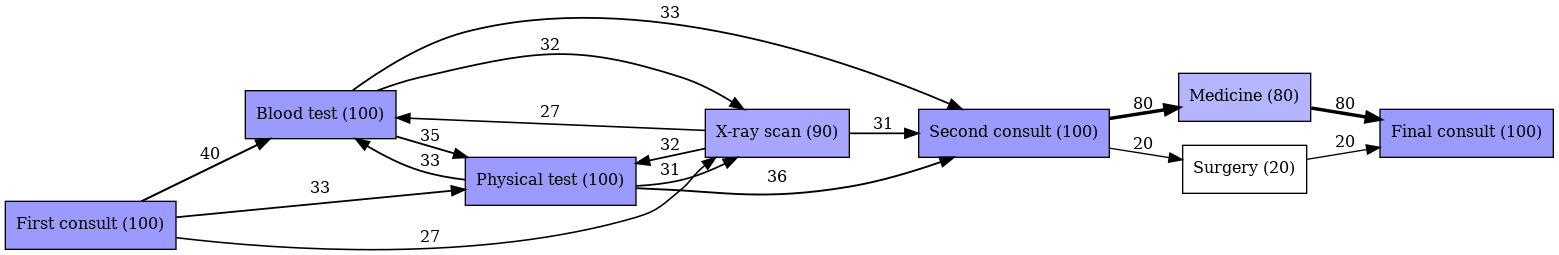

In [23]:
## Import the dfg_discovery algorithm
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
## Import the dfg visualization object
from pm4py.visualization.dfg import visualizer as dfg_visualization
#Create graph from log
dfg = dfg_discovery.apply(log)
# Visualise
gviz = dfg_visualization.apply(dfg, log=log, variant=dfg_visualization.Variants.FREQUENCY)
dfg_visualization.view(gviz)

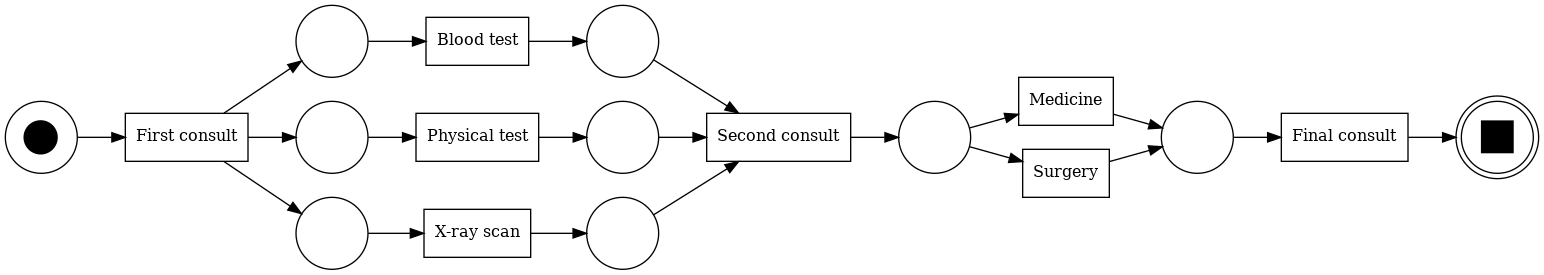

In [24]:
## Alpha_miner algorithm
net, im, fm = pm4py.discover_petri_net_alpha(log_csv)

# Visualise
pm4py.view_petri_net(net, im, fm, format='png')


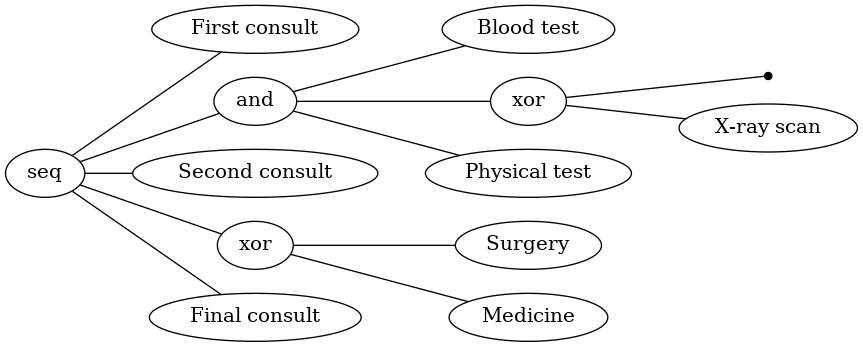

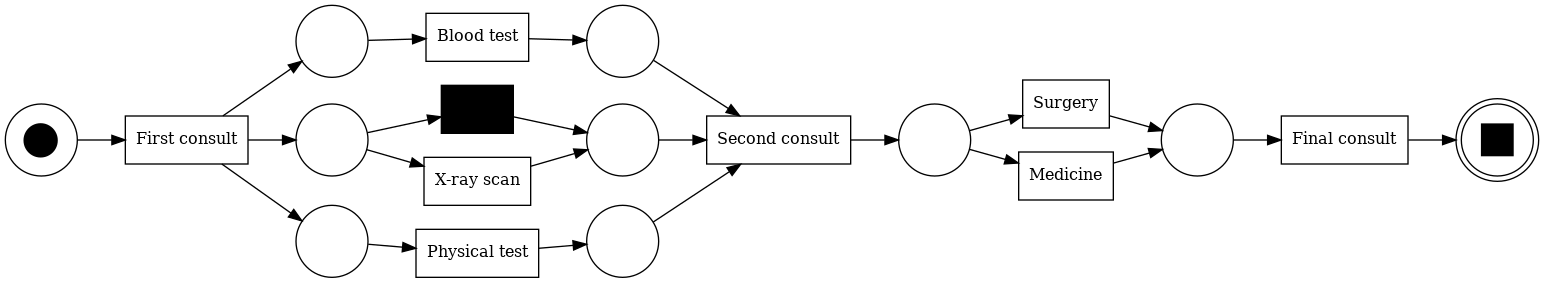

In [25]:
# Discover process tree using inductive miner
process_tree = pm4py.discover_process_tree_inductive(log_csv)

pm4py.view_process_tree(process_tree, format='png')

# Discover petri net using inductive miner
net, im, fm = pm4py.discover_petri_net_inductive(log_csv)

pm4py.view_petri_net(net, im, fm, format='png')




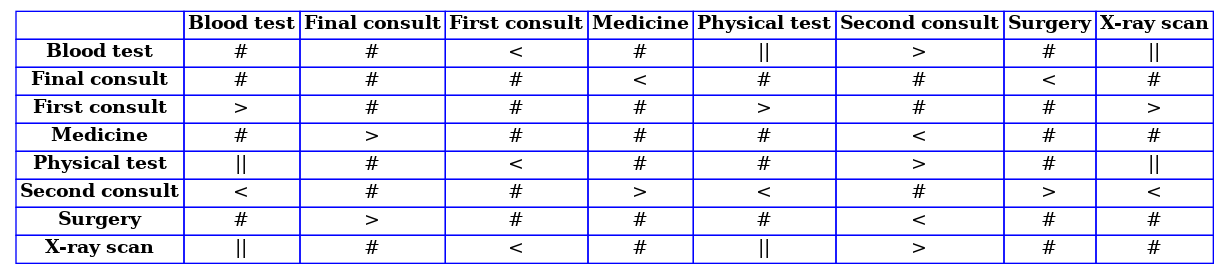

In [26]:
footprints = pm4py.discover_footprints(log_csv)
pm4py.view_footprints(footprints, format='png')

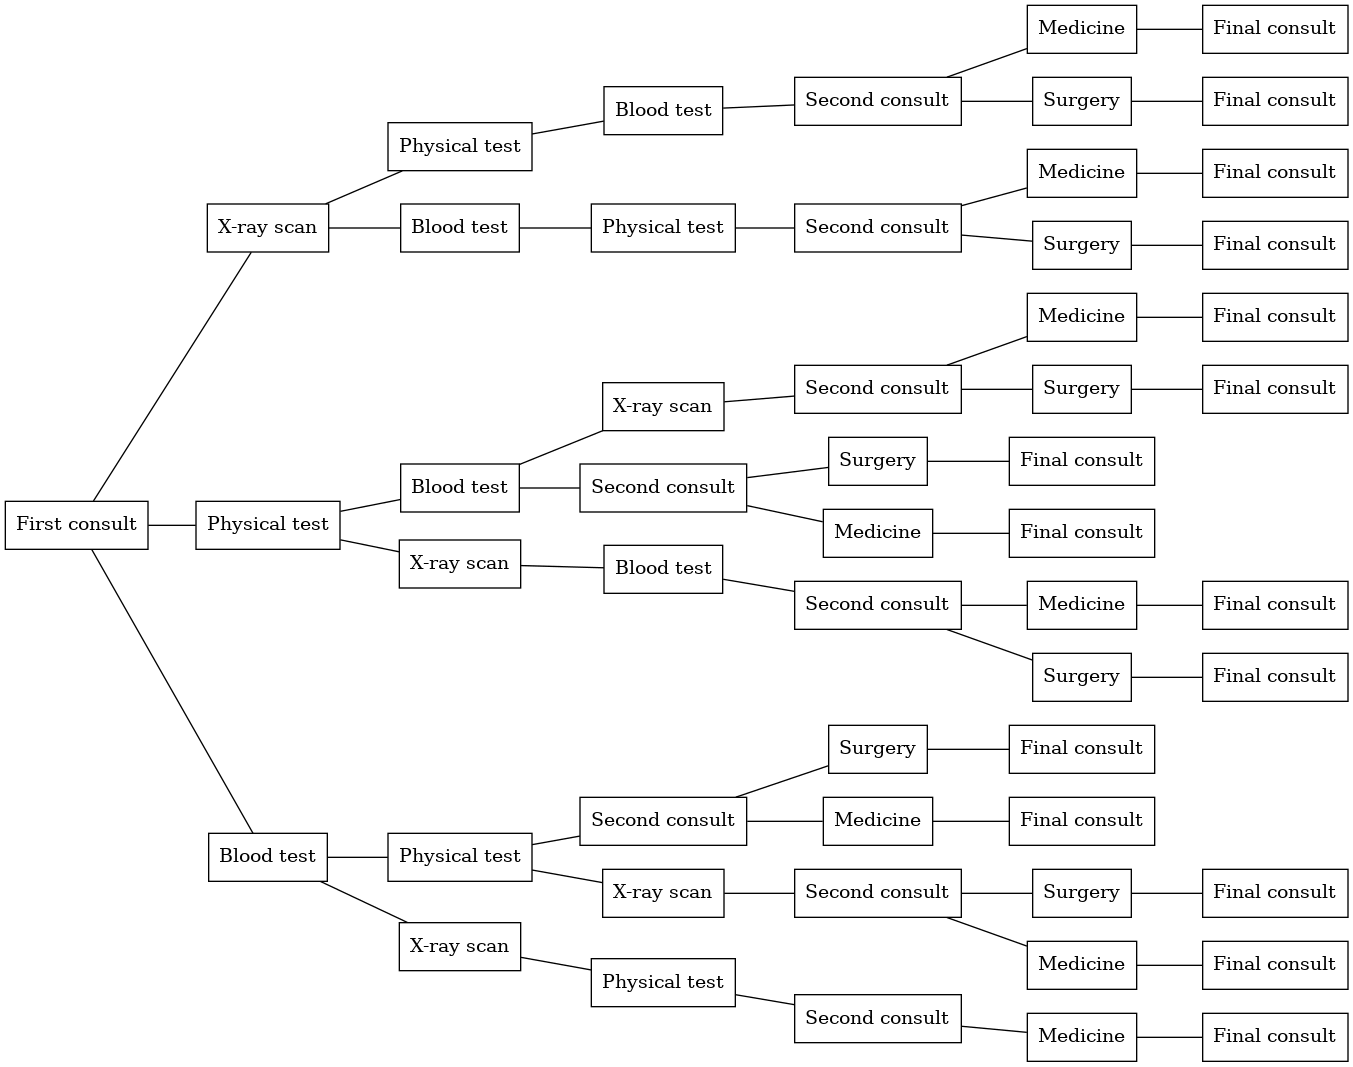

In [27]:
prefix_tree = pm4py.discover_prefix_tree(log_csv)
pm4py.view_prefix_tree(prefix_tree, format='png')


In [28]:
tbr_diagnostics = pm4py.conformance_diagnostics_token_based_replay(log_csv, net, im, fm)
diagnostics_df = pd.DataFrame.from_dict(tbr_diagnostics)

diagnostics_df


replaying log with TBR, completed traces :: 100%|██████████| 15/15 [00:00<00:00, 560.47it/s]


,trace_is_fit,trace_fitness,activated_transitions,reached_marking,enabled_transitions_in_marking,transitions_with_problems,missing_tokens,consumed_tokens,remaining_tokens,produced_tokens
0,True,1.0,"[(abce72b6-0982-4180-9058-ae5c3afd2d57, 'First...",{sink: 1},{},[],0,10,0,10
1,True,1.0,"[(abce72b6-0982-4180-9058-ae5c3afd2d57, 'First...",{sink: 1},{},[],0,10,0,10
2,True,1.0,"[(abce72b6-0982-4180-9058-ae5c3afd2d57, 'First...",{sink: 1},{},[],0,10,0,10
3,True,1.0,"[(abce72b6-0982-4180-9058-ae5c3afd2d57, 'First...",{sink: 1},{},[],0,10,0,10
4,True,1.0,"[(abce72b6-0982-4180-9058-ae5c3afd2d57, 'First...",{sink: 1},{},[],0,10,0,10
...,...,...,...,...,...,...,...,...,...,...
95,True,1.0,"[(abce72b6-0982-4180-9058-ae5c3afd2d57, 'First...",{sink: 1},{},[],0,10,0,10
96,True,1.0,"[(abce72b6-0982-4180-9058-ae5c3afd2d57, 'First...",{sink: 1},{},[],0,10,0,10
97,True,1.0,"[(abce72b6-0982-4180-9058-ae5c3afd2d57, 'First...",{sink: 1},{},[],0,10,0,10
98,True,1.0,"[(abce72b6-0982-4180-9058-ae5c3afd2d57, 'First...",{sink: 1},{},[],0,10,0,10
